# Transform DICOM metadata

* Download DICOM metadata you want to transform
* Download ODBC Driver 18 from web <https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/install-microsoft-odbc-driver-sql-server-macos?view=sql-server-ver16>
* OMOP CDM instance with the connection string and authentication information. If your database access limits IP addresses, make sure to add your IP address before running the connection strings.
* OMOP CDM Person table should be updated with demographic information, if available, before running this code. If not, you can upload the Person table using DICOM Patient metadata information.
* Install SQL processing package, i.e., pyodbc.

In [3]:
# Load your DICOM metadata file
import pandas as pd

flat_metadata_df = pd.read_pickle('./files/ADNI/all_metadata_long.pkl')

In [4]:
print(flat_metadata_df.shape)

(691224, 5)


In [5]:
print(flat_metadata_df['SeriesUID'].nunique())

4756


In [ ]:
# Import concept table from the SQL database
# *** run this after uploading DICOM custom concepts ***

import psycopg2

# conncet to your database 
conn = psycopg2.connect(
    database="",
    user="",
    password="",
    host="",
    port="",
    connect_timeout = 6000
)
 
cursor = conn.cursor()

sql = "select * from dbo.concept"
concept_df = pd.read_sql_query(sql, conn)

sql = "select * from dbo.concept_relationship"
concept_relationship_df = pd.read_sql_query(sql, conn)

# close the cursor and connection
cursor.close()
conn.close()

/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_9171/3338844226.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  concept_df = pd.read_sql_query(sql, conn)
/var/folders/wh/p78ddrtn39j879rx8h8fs8fr0000gn/T/ipykernel_9171/3338844226.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  concept_relationship_df = pd.read_sql_query(sql, conn)


In [36]:
# Get OMOP concepts for DICOM attributes
metadata_omop = flat_metadata_df.merge(concept_df[concept_df['vocabulary_id']=="DICOM"][['concept_id', 'concept_code', 'concept_name']], how = 'left', left_on = 'Tag', right_on = 'concept_code')
print(metadata_omop.shape)

(691224, 8)


In [8]:
# update concept_id data type to int
metadata_omop['concept_id'] = metadata_omop['concept_id'].astype('Int64')

In [9]:
# inspect number of DICOM metadata elements that will be added to OMOP CDM
metadata_omop[~metadata_omop['concept_id'].isna()].shape #434,063 ~62%

(434063, 8)

In [15]:
metadata_omop[metadata_omop['concept_id'].isna()]['vr'].unique()

array(['LO', 'CS', 'DS', 'SL', 'IS', 'FD', 'US', 'SH', 'UI', 'SS', 'FL',
       'DT', 'UL', 'SQ'], dtype=object)

In [ ]:
# Tags with no OMOP concepts - private tags
print(metadata_omop[metadata_omop['concept_id'].isna()]['Tag'].nunique())
print(metadata_omop[metadata_omop['concept_id'].isna()].shape[0])
metadata_omop[metadata_omop['concept_id'].isna()]['Tag'].unique()[:30]

518
257161


array(['00190010', '00191008', '0019100B', '00191012', '00191013',
       '00191014', '00191015', '00191017', '00191018', '00291008',
       '00291018', '00511008', '00511016', '00191016', '0019100A',
       '00191029', '00191028', '00090010', '00091002', '00091004',
       '00091027', '000910E3', '000910E9', '0019100F', '00191011',
       '00191019', '0019101A', '0019101B', '0019101E', '0019105A'],
      dtype=object)

In [11]:
# inspect any null values
metadata_omop[(~metadata_omop['concept_id'].isna()) & (metadata_omop['Value'].isna())].shape 

(26618, 8)

In [12]:
# inspect multi values
metadata_omop[(metadata_omop['Value'].str.contains(",", na=False)) & 
              (metadata_omop['vr'].isin(['AT', 'CS', 'DA', 'DT', 'DS', 'FL', 'FD', 'IS', 'SL', 'SS', 'SV', 'TM', 'UL', 'US', 'UV']))
              ]['concept_name'].unique()

array(['Image Type', 'Scanning Sequence', 'Sequence Variant',
       'Acquisition Matrix', nan, 'Image Position (Patient)',
       'Image Orientation (Patient)', 'Pixel Spacing',
       'Red Palette Color Lookup Table Descriptor',
       'Green Palette Color Lookup Table Descriptor',
       'Blue Palette Color Lookup Table Descriptor', 'Scan Options',
       'Diffusion Gradient Orientation', 'Chemical Shift Reference',
       'Velocity Encoding Direction', 'Window Center', 'Window Width'],
      dtype=object)

In [13]:
# create a list of Tags to exclude
exclude = metadata_omop[(~metadata_omop['concept_id'].isna()) & 
              (metadata_omop['vr'].isin(['AT', 'CS', 'DA', 'DT', 'DS', 'FL', 'FD', 'IS', 'SL', 'SS', 'SV', 'TM', 'UL', 'US', 'UV'])) & 
              (metadata_omop['Value'].str.len()>50) & 
              (metadata_omop['Value']!= "{}")]['Tag'].unique()

exclude

array(['00080008', '00200032', '00200037', '00189089', '00180022'],
      dtype=object)

In [14]:
selected_metadata = metadata_omop[(~metadata_omop['concept_id'].isna()) & #private tags 434,063
                                  (~metadata_omop['Value'].isna()) & #null values 26,618
                                  (~metadata_omop['Tag'].isin(exclude)) & #tags with long characters 17,066
                                  ((metadata_omop['vr'].isin(['AT', 'CS', 'DA', 'DT', 'DS', 'FL', 'FD', 'IS', 'SL', 'SS', 'SV', 'TM', 'UL', 'US', 'UV'])) |
                                   (metadata_omop['Tag'].isin(["00080070"])))] #list of included tags & manufacturer needed in the analysis
selected_metadata.shape #283,948 ~41%

(283948, 8)

In [17]:
selected_metadata['SeriesUID'].nunique()

4756

In [18]:
selected_metadata['concept_name'].nunique()

159

In [19]:
test = selected_metadata.groupby(['SeriesUID'])['concept_id'].count().reset_index()

In [20]:
print(test['concept_id'].median(), test['concept_id'].mean())

58.0 59.703111858704794


## Image Occurrence Table Staging

In [23]:
# inspect tags needed for imaging extension tables
tags_for_columns = ["00080020", "00100020", "00080060", "00180015"]
metadata_omop[metadata_omop['Tag'].isin(tags_for_columns)].groupby('Tag')['SeriesUID'].nunique()

Tag
00080020    4756
00080060    4756
00100020    4756
00180015    3987
Name: SeriesUID, dtype: int64

In [15]:
# boby part examined: 769 series missing this value
metadata_omop[metadata_omop['Tag']=="00180015"].groupby('Value')['SeriesUID'].count()

Value
BRAIN        3484
HEAD          403
HEAD_NECK     100
Name: SeriesUID, dtype: int64

In [21]:
# study date
metadata_omop[metadata_omop['Tag']=="00080020"]['Value'].head()

5      20171204
104    20171204
203    20171204
311    20171204
411    20171204
Name: Value, dtype: object

In [10]:
# modality
metadata_omop[metadata_omop['Tag']=="00080060"].groupby('Value')['SeriesUID'].count()

Value
MR    4756
Name: SeriesUID, dtype: int64

In [24]:
df_subset = metadata_omop[metadata_omop['Tag'].isin(tags_for_columns)][['StudyUID', 'SeriesUID', 'Tag', 'Value']]
df_subset = df_subset.pivot(index=['StudyUID', 'SeriesUID'], columns='Tag', values='Value').reset_index()
df_subset.columns.name = None
print(df_subset.shape)

(4756, 6)


In [26]:
# Load person_id from registry id map table (created using ADNI demographic file)
df_id = pd.read_csv('./files/OMOP CDM Staging/registry_idmap.csv')
print(df_id.shape)

(4152, 3)


In [27]:
df_subset = df_subset.merge(df_id[['source_id', 'person_id']], how = 'left', left_on = '00100020', right_on = 'source_id')

In [125]:
df_subset.source_id.nunique()

289

In [28]:
# use Athena to get standard concept ids
df_subset['anatomic_site_concept_id'] = 4119359 # since the values are too varied and some are empty, we will use the most popular entry, BRAIN
df_subset['modality_concept_id'] = 4013636 # MR
df_subset['image_occurrence_date'] = pd.to_datetime(df_subset['00080020'])
df_subset['wadors_uri'] = 'https://imgextpoc-adnidicom.dicom.azurehealthcareapis.com/v2/studies/' + df_subset['StudyUID'] + '/series/' + df_subset['SeriesUID']
df_subset['visit_type_concept_id'] = 32817 #EHR
df_subset['visit_concept_id'] = 9202 #outpatient visit
print(df_subset.shape)

(4756, 14)


In [21]:
# set IDs
df_subset['image_occurrence_id'] = pd.Series(range(1, 1 + len(df_subset)))
df_subset['procedure_occurrence_id'] = pd.Series(range(1, 1 + len(df_subset)))
df_subset['visit_occurrence_id'] = pd.Series(range(1, 1 + len(df_subset)))

In [22]:
df_subset.to_pickle('./files/OMOP CDM Staging/image_occurrence_staging_v3.pkl')

## Prepare other tags

In [23]:
# inspect the most popular tags that will be added to the OMOP CDM
metadata_omop_tag_counts = metadata_omop[~metadata_omop['concept_id'].isna()][['concept_name', 'vr']].value_counts()
metadata_omop_tag_counts[:20]

concept_name                  vr
Series Instance UID           UI    4756
Study Time                    TM    4756
Study Date                    DA    4756
Position Reference Indicator  LO    4756
Device Serial Number          LO    4756
Pixel Representation          US    4756
Software Versions             LO    4756
Series Time                   TM    4756
Series Number                 IS    4756
Patient Position              CS    4756
Series Description            LO    4756
Photometric Interpretation    CS    4756
High Bit                      US    4756
Referring Physician's Name    PN    4756
Image Type                    CS    4756
Instance Number               IS    4756
Series Date                   DA    4756
MR Acquisition Type           CS    4756
Magnetic Field Strength       DS    4756
Manufacturer                  LO    4756
Name: count, dtype: int64

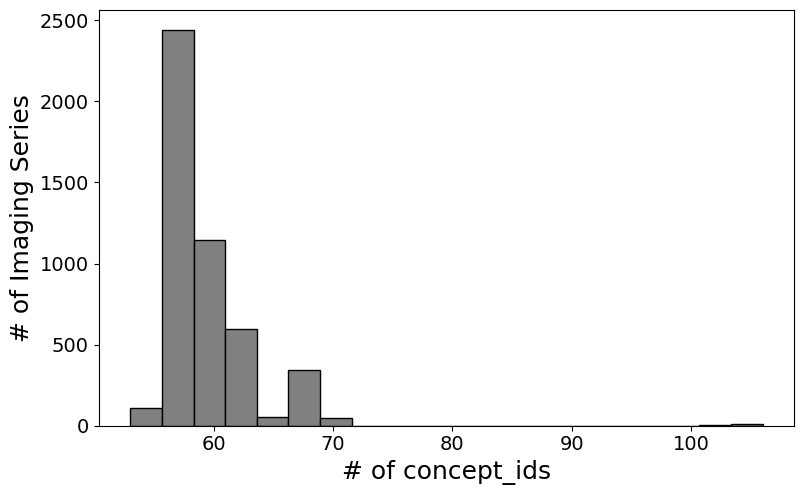

In [24]:
# Create a histogram of number of metadata elements per series
import matplotlib.pyplot as plt

# Get the number of concept_ids per SeriesUID
concepts_per_series = selected_metadata['SeriesUID'].value_counts()

# Plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(concepts_per_series, bins=20, edgecolor='black', color='grey')
plt.xlabel('# of concept_ids', fontsize=18)
plt.ylabel('# of Imaging Series', fontsize=18)
plt.tight_layout()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

In [135]:
selected_metadata[selected_metadata['vr']=='CS'].shape

(58552, 8)

In [29]:
att_to_value = concept_relationship_df[concept_relationship_df['relationship_id']=="Maps to value"][['concept_id_1', 'concept_id_2']].merge(
    concept_df[['concept_id', 'concept_code', 'concept_name']], left_on = 'concept_id_2', right_on = 'concept_id')

In [30]:
new_image_features_cs = selected_metadata[selected_metadata['vr']=='CS'].merge(att_to_value, how = 'inner', left_on = ['concept_id', 'Value'], right_on = ['concept_id_1', 'concept_code'])

In [31]:
print(new_image_features_cs.shape)
new_image_features_cs[['Tag','concept_name_x', 'Value']].drop_duplicates()

(8643, 13)


Tag      concept_name_x  Value
0    00180015  Body Part Examined  BRAIN
1    00185100    Patient Position    HFS
767  00180015  Body Part Examined   HEAD

In [32]:
# inspect values with unmatched OMOP concepts
omop_value_not_found_cs = selected_metadata[(selected_metadata['vr']=='CS') & 
                                            (~selected_metadata['Value'].isin(['BRAIN', 'HFS', 'HEAD']))
                                            ][['Tag', 'concept_name', 'Value']].drop_duplicates().reset_index(drop=True)
print(omop_value_not_found_cs.shape)
omop_value_not_found_cs.head()

(117, 3)


Tag            concept_name       Value
0  00080005  Specific Character Set  ISO_IR 100
1  00080060                Modality          MR
2  00100040           Patient's Sex           F
3  00180020       Scanning Sequence      GR, IR
4  00180021        Sequence Variant  SK, SP, MP

In [33]:
# non-CS values
new_image_features_non_cs = selected_metadata[~selected_metadata['Value'].isin(['BRAIN', 'HFS', 'HEAD'])]
new_image_features_non_cs = new_image_features_non_cs.rename(columns={'concept_id': 'concept_id_x',
                                                                      'concept_name': 'concept_name_x',
                                                                      'concept_code': 'concept_code_x'})
print(new_image_features_non_cs.shape)

(275305, 8)


In [34]:
new_image_features = pd.concat([new_image_features_cs, new_image_features_non_cs])
new_image_features['concept_id_y'] = new_image_features['concept_id_y'].astype('Int64')
print(new_image_features.shape) #283948

(283948, 13)


In [ ]:
new_image_features = new_image_features.merge(
    df_subset[['image_occurrence_id', 'person_id', 'SeriesUID', 'image_occurrence_date', 'anatomic_site_concept_id']], 
    how = 'left', on = 'SeriesUID')

In [ ]:
new_image_features['image_feature_event_field_id'] = 1147330
new_image_features['image_feature_event_type_id'] = 32817
new_image_features['image_feature_event_id'] = range(1, len(new_image_features)+1)
new_image_features.head()

In [49]:
new_image_features.vr.unique()

array(['CS', 'TM', 'DA', 'LO', 'DS', 'IS', 'US', 'UL', 'SS', 'FL', 'FD'],
      dtype=object)

In [50]:
new_image_features['value_as_number'] = new_image_features.apply(lambda row: row['Value'] if (row['vr'] != 'CS') | (row['vr'] != 'LO') else None, axis=1)
new_image_features['measurement_source_value'] = new_image_features['Value'].astype(str).str[:50]
new_image_features = new_image_features.where(pd.notnull(new_image_features), None)

In [51]:
new_image_features.columns

Index(['StudyUID', 'SeriesUID', 'Tag', 'vr', 'Value', 'concept_id_x',
       'concept_code_x', 'concept_name_x', 'concept_id_1', 'concept_id_2',
       'concept_id_y', 'concept_code_y', 'concept_name_y',
       'image_occurrence_id', 'person_id', 'image_occurrence_date',
       'anatomic_site_concept_id', 'image_feature_event_field_id',
       'image_feature_event_type_id', 'image_feature_event_id',
       'value_as_number', 'measurement_source_value'],
      dtype='object')

In [52]:
new_image_features['value_as_number'] = pd.to_numeric(new_image_features['Value'], errors='coerce')

In [53]:
new_image_features.to_pickle('./files/ADNI/image_series_metadata_v3.pkl')